# NBA Regular Season Success Analysis: Financial Strategies and Roster Engineering

## 1. Project Overview
This project analyzes the key factors influencing the **regular season** success of NBA teams during the 2024-2025 season. Deviating from pure on-court analytics, this study focuses on **"front office" decisions**.

Under the constraints of the Salary Cap and the new CBA (Collective Bargaining Agreement), we statistically examine how financial allocation, roster stability, and age demographics impact winning.

### Objectives
1.  **Financial Strategies:** Analyze the impact of `Top3_Salary_Share` and `Luxury_Tax` on success.
2.  **Roster Engineering:** Quantify the role of `Minutes_Continuity` and `Avg_Age`.
3.  **Inefficiency:** Measure the drag caused by `Dead_Money`.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="notebook", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'sans-serif'

print("✅ Libraries Imported Successfully.")

✅ Libraries Imported Successfully.


## 2. Data Loading and Cleaning
The dataset consists of 30 NBA teams with variables aggregated from the 2024-2025 regular season.
* **Source:** Basketball-Reference, Spotrac.
* **Key Metrics:** Win Percentage, Salary Cap Data, Continuity, and Advanced Ratings.

In [ ]:
df = pd.read_csv('dsa.csv')

df.columns = [c.strip() for c in df.columns]

display(df.head())

print(f"Dataset Shape: {df.shape[0]} Teams, {df.shape[1]} Features")

,Rank,Team,Wins,Losses,Win_Percentage,Defensive_Rating,Avg_Age,Avg_Age_perMinute,Minutes_Continuity,Total_Cap_Allocated,Active_Cap,Luxury_Tax_Bill,Active_Top3_Cap,Top3_Salary_Share,Dead_Cap,Dead_Money_Share,Season
0,1,OKC,68,14,0.829268,107.5,24.2,25.5,79,166001694,162209242,0.0,82859950,0.589381,3792452,0.026976,2025
1,2,CLE,64,18,0.780488,112.2,26.0,27.0,92,178212347,169371096,0.0,93832409,0.667428,491175,0.003494,2025
2,3,BOS,61,21,0.743902,111.1,27.5,27.2,97,197048229,193098445,66664570.0,114054140,0.811265,0,0.000000,2025
3,4,HOU,52,30,0.634146,110.8,25.7,26.6,92,173496349,161552948,0.0,78702108,0.559807,7768363,0.055256,2025
4,5,NYK,51,31,0.621951,114.3,26.5,29.1,57,188877651,188001268,14976511.0,110803733,0.788145,876383,0.006234,2025


Dataset Shape: 30 Teams, 17 Features


## 3. Exploratory Data Analysis (EDA)

Before hypothesis testing, we examine the distribution and statistical summary of our independent and dependent variables.

In [ ]:
eda_vars = ['Win_Percentage', 'Top3_Salary_Share', 'Luxury_Tax_Bill', 
            'Minutes_Continuity', 'Defensive_Rating', 'Dead_Money_Share', 'Avg_Age']

desc_stats = df[eda_vars].describe().T[['count', 'mean', 'std', 'min', '50%', 'max']]
display(desc_stats)

,count,mean,std,min,50%,max
Win_Percentage,30.0,5.000000e-01,1.628607e-01,0.207317,0.493902,8.292683e-01
Top3_Salary_Share,30.0,6.909490e-01,1.595221e-01,0.402303,0.676799,1.071135e+00
Luxury_Tax_Bill,30.0,1.735316e+07,4.063770e+07,0.000000,0.000000,1.883038e+08
Minutes_Continuity,30.0,6.810000e+01,1.469072e+01,38.000000,67.000000,9.700000e+01
Defensive_Rating,30.0,1.141900e+02,3.412083e+00,107.000000,114.500000,1.204000e+02
Dead_Money_Share,30.0,4.476948e-02,7.679214e-02,0.000000,0.026459,4.154615e-01
Avg_Age,30.0,2.576667e+01,1.272070e+00,23.800000,25.700000,2.810000e+01


### Correlation Matrix
Visualizing the relationships between financial/roster metrics and winning percentage.

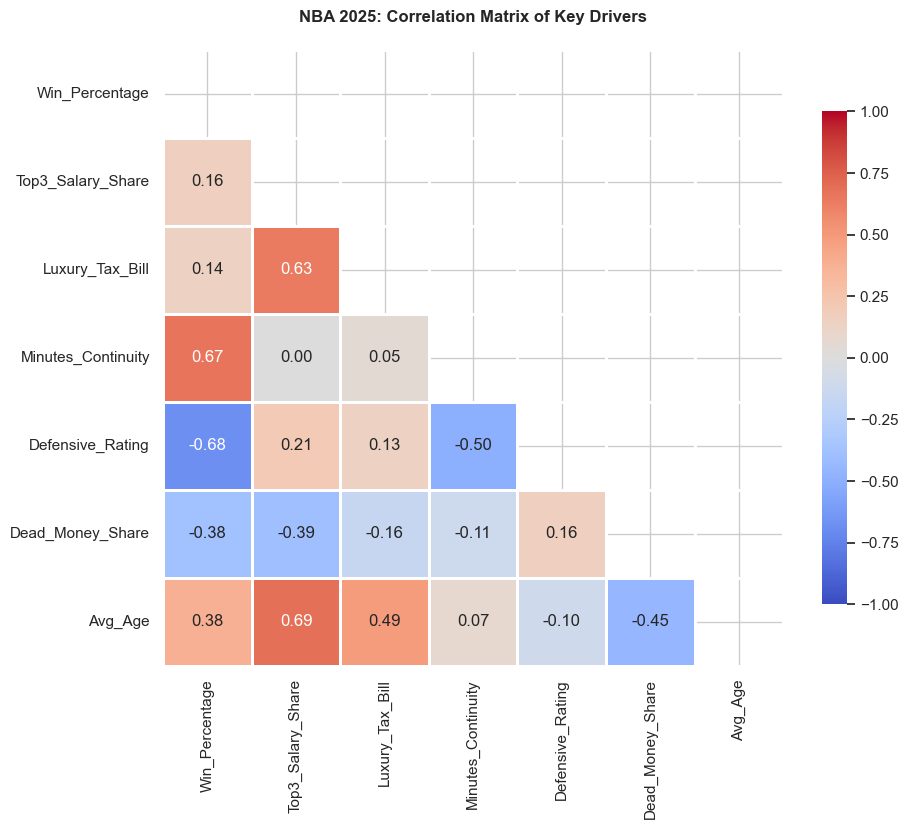

In [29]:
plt.figure(figsize=(10, 8))
corr_matrix = df[eda_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=1, vmin=-1, vmax=1, cbar_kws={"shrink": .8})

plt.title('NBA 2025: Correlation Matrix of Key Drivers', fontweight='bold', pad=20)
plt.show()

### Helper Functions for Visualization
Defining custom plotting functions to handle team annotations and varied chart types.

In [ ]:
def add_team_labels(df, x_col, y_col, ax, offset=0.002):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].iloc[i], y=df[y_col].iloc[i], s=df['Team'].iloc[i], 
                fontdict=dict(color='black', size=9, weight='bold'),
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

def plot_hypothesis_scatter(df, x_col, y_col, title, x_label):
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    sns.regplot(data=df, x=x_col, y=y_col, ci=None, ax=ax,
                scatter_kws={'s':100, 'alpha':0.6, 'color':'#3498db'}, 
                line_kws={'color':'red', 'ls':'--', 'lw':2})
    add_team_labels(df, x_col, y_col, ax)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(x_label)
    plt.ylabel("Win Percentage")
    plt.grid(True, alpha=0.3)
    plt.show()

print("✅ Helper functions defined.")

✅ Helper functions defined.


## 4. Hypothesis Testing

### Hypothesis 1: Financial Strategies (Superstars)
Does concentrating salary in 2-3 superstars yield a higher return in wins?

* **$H_0$**: There is no significant relationship between `Top3_Salary_Share` and `Win_Percentage`.
* **$H_1$**: There is a positive relationship; teams that spend more on top stars win more.

Correlation (r): 0.1571
P-value: 0.4072
Result: Fail to Reject Null Hypothesis (No Significant Relationship)


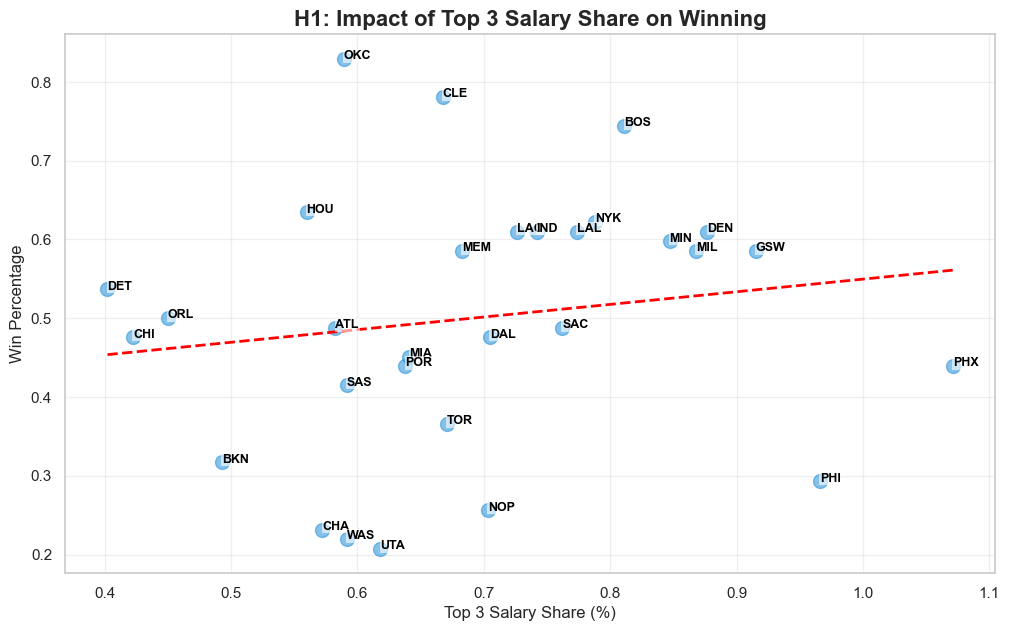

In [ ]:
r, p = stats.pearsonr(df['Top3_Salary_Share'], df['Win_Percentage'])

print(f"Correlation (r): {r:.4f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("Result: Reject Null Hypothesis (Significant Relationship)")
else:
    print("Result: Fail to Reject Null Hypothesis (No Significant Relationship)")

plot_hypothesis_scatter(df, 'Top3_Salary_Share', 'Win_Percentage', 
                        "H1: Impact of Top 3 Salary Share on Winning", 
                        "Top 3 Salary Share (%)")

### Hypothesis 2: Luxury Tax Impact
Is paying the luxury tax a statistically significant predictor of regular season success?

* **$H_0$**: Paying Luxury Tax has no effect on `Win_Percentage`.
* **$H_1$**: Paying Luxury Tax is positively correlated with `Win_Percentage`.

T-Statistic: 1.1082
P-value: 0.2772
------------------------------------------------------------
CONCLUSION: ❌ FAIL TO REJECT THE NULL HYPOTHESIS.
Interpretation: Paying the luxury tax does not yield a statistically significant advantage in regular season success.
------------------------------------------------------------


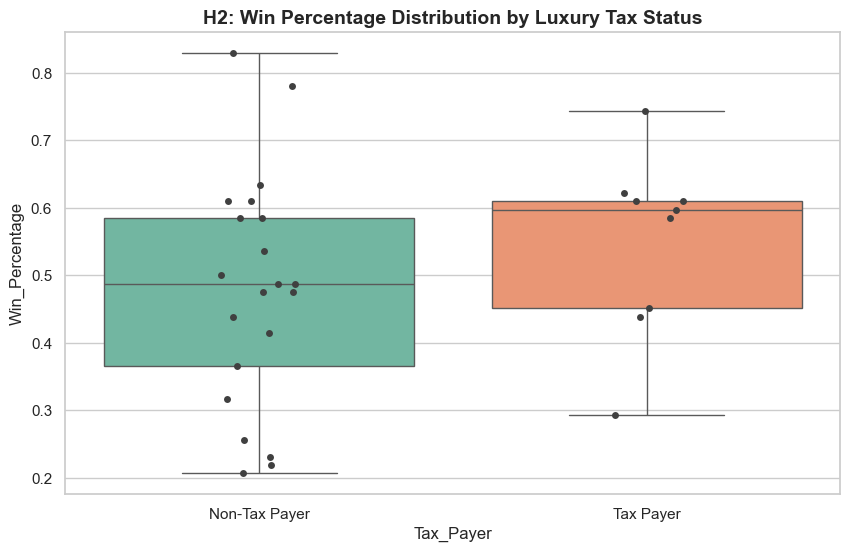

In [ ]:
df['Tax_Payer'] = np.where(df['Luxury_Tax_Bill'] > 0, 'Tax Payer', 'Non-Tax Payer')

payers = df[df['Tax_Payer'] == 'Tax Payer']['Win_Percentage']
non_payers = df[df['Tax_Payer'] == 'Non-Tax Payer']['Win_Percentage']
t_stat, p_val = stats.ttest_ind(payers, non_payers)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print("-" * 60)

if p_val < 0.05:
    print("CONCLUSION: ✅ REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: There is a statistically significant difference in win percentages between luxury tax payers and non-payers.")
else:
    print("CONCLUSION: ❌ FAIL TO REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: Paying the luxury tax does not yield a statistically significant advantage in regular season success.")
print("-" * 60)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Tax_Payer', y='Win_Percentage', data=df, palette="Set2")
sns.stripplot(x='Tax_Payer', y='Win_Percentage', data=df, color=".25", size=5)
plt.title("H2: Win Percentage Distribution by Luxury Tax Status", fontsize=14, fontweight='bold')
plt.show()

### Hypothesis 3: Roster Engineering (Continuity)
What is the quantitative impact of "roster chemistry," as measured by `Minutes_Continuity`?

* **$H_0$**: Roster continuity implies no change in success.
* **$H_1$**: Higher `Minutes_Continuity` is positively correlated with `Win_Percentage`.

Pearson Correlation Coefficient (r): 0.6714
P-value: 0.0000
------------------------------------------------------------
CONCLUSION: ✅ REJECT THE NULL HYPOTHESIS.
Interpretation: Roster continuity (Minutes_Continuity) exhibits a significant positive correlation with regular season success.
------------------------------------------------------------


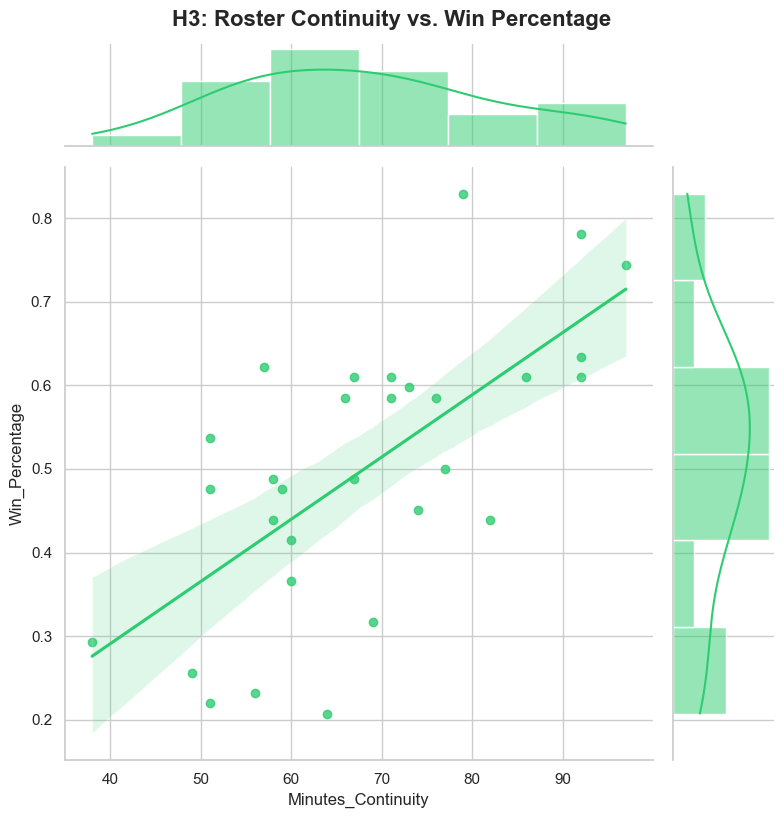

In [ ]:
r, p = stats.pearsonr(df['Minutes_Continuity'], df['Win_Percentage'])

print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"P-value: {p:.4f}")
print("-" * 60)

if p < 0.05:
    print("CONCLUSION: ✅ REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: Roster continuity (Minutes_Continuity) exhibits a significant positive correlation with regular season success.")
else:
    print("CONCLUSION: ❌ FAIL TO REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: No significant linear relationship was observed between roster continuity and winning percentage.")
print("-" * 60)


g = sns.jointplot(data=df, x='Minutes_Continuity', y='Win_Percentage', kind="reg", 
                  color="#2ecc71", height=8)
g.fig.suptitle("H3: Roster Continuity vs. Win Percentage", fontsize=16, fontweight='bold', y=1.02)
plt.show()

### Hypothesis 4: Experience and Defense
Do veteran teams demonstrate empirically superior defensive performance?

* **$H_0$**: There is no relationship between `Avg_Age` and `Defensive_Rating`.
* **$H_1$**: There is a **negative** relationship (Older age -> Lower/Better Def Rating).

Pearson Correlation Coefficient (r): -0.1042
P-value: 0.5836
------------------------------------------------------------
CONCLUSION: ❌ FAIL TO REJECT THE NULL HYPOTHESIS.
Interpretation: There is no statistically significant evidence that older, more experienced teams perform better defensively.
------------------------------------------------------------


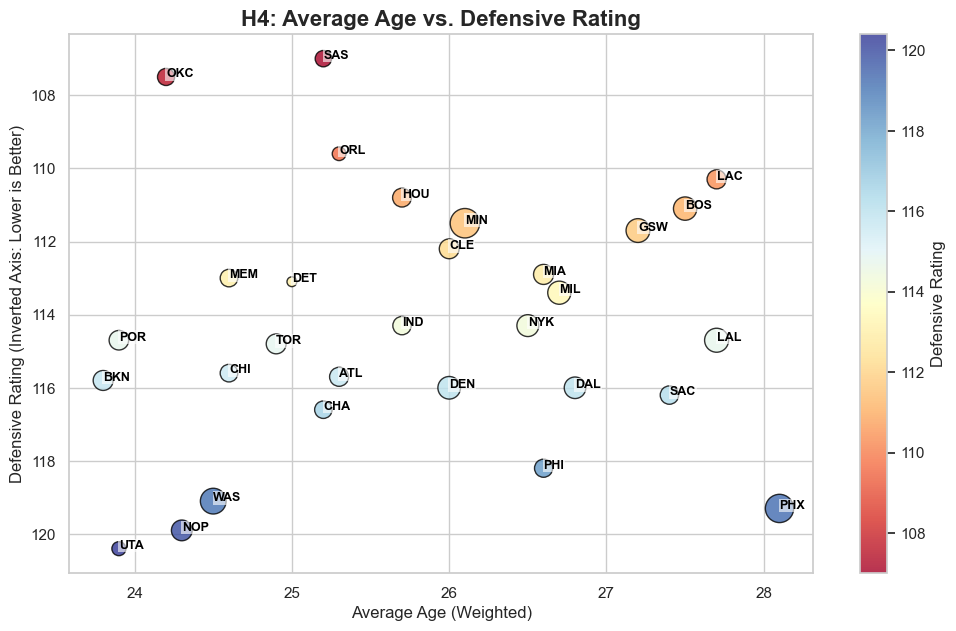

In [ ]:
r, p = stats.pearsonr(df['Avg_Age'], df['Defensive_Rating'])

print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"P-value: {p:.4f}")
print("-" * 60)

if p < 0.05:
    print("CONCLUSION: ✅ REJECT THE NULL HYPOTHESIS.")
    if r < 0:
        print("Interpretation: A significant negative correlation exists. As the average age increases, the Defensive Rating decreases (indicating better defensive performance).")
    else:
        print("Interpretation: A significant relationship exists, but contrary to the hypothesis, older teams showed worse defensive ratings.")
else:
    print("CONCLUSION: ❌ FAIL TO REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: There is no statistically significant evidence that older, more experienced teams perform better defensively.")
print("-" * 60)

plt.figure(figsize=(12, 7))
sizes = (df['Total_Cap_Allocated'] - df['Total_Cap_Allocated'].min()) / \
        (df['Total_Cap_Allocated'].max() - df['Total_Cap_Allocated'].min()) * 400 + 50

ax = plt.gca()
sc = ax.scatter(df['Avg_Age'], df['Defensive_Rating'], s=sizes, c=df['Defensive_Rating'], 
                cmap="RdYlBu", alpha=0.8, edgecolors="black")

add_team_labels(df, 'Avg_Age', 'Defensive_Rating', ax)

plt.colorbar(sc, label="Defensive Rating")
plt.title("H4: Average Age vs. Defensive Rating", fontsize=16, fontweight='bold')
plt.xlabel("Average Age (Weighted)")
plt.ylabel("Defensive Rating (Inverted Axis: Lower is Better)")
plt.gca().invert_yaxis()
plt.show()

### Hypothesis 5: The "Dead Money" Drag
What is the "cost" of bad contracts?

* **$H_0$**: Dead Money has no impact on winning.
* **$H_1$**: There is a negative relationship between `Dead_Money_Share` and `Win_Percentage`.

Spearman Rank Correlation (ρ): -0.4116
P-value: 0.0238
------------------------------------------------------------
CONCLUSION: ✅ REJECT THE NULL HYPOTHESIS.
Interpretation: There is a statistically significant negative correlation. Teams with higher shares of 'Dead Money' tend to rank lower in winning percentage.
------------------------------------------------------------


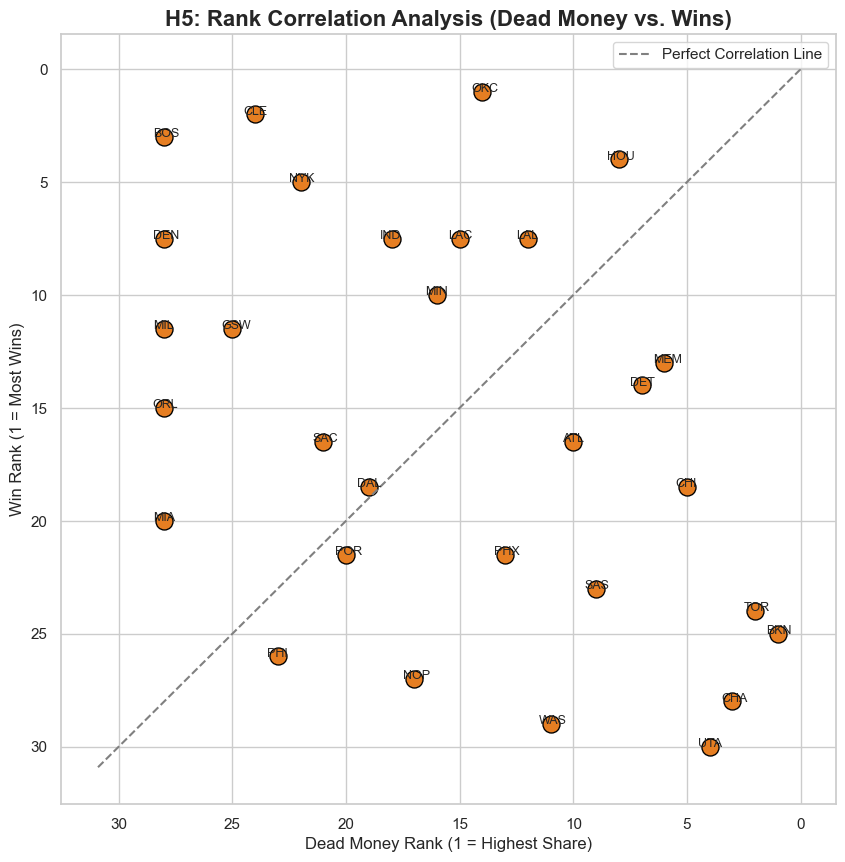

In [ ]:
df['Rank_Dead_Money'] = df['Dead_Money_Share'].rank(ascending=False) 
df['Rank_Wins'] = df['Win_Percentage'].rank(ascending=False)        

r_s, p_s = stats.spearmanr(df['Dead_Money_Share'], df['Win_Percentage'])

print(f"Spearman Rank Correlation (ρ): {r_s:.4f}")
print(f"P-value: {p_s:.4f}")
print("-" * 60)

if p_s < 0.05:
    print("CONCLUSION: ✅ REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: There is a statistically significant negative correlation. Teams with higher shares of 'Dead Money' tend to rank lower in winning percentage.")
else:
    print("CONCLUSION: ❌ FAIL TO REJECT THE NULL HYPOTHESIS.")
    print("Interpretation: The amount of dead money on the cap sheet does not significantly predict a team's win ranking.")
print("-" * 60)

plt.figure(figsize=(10, 10))
ax = plt.gca()
sns.scatterplot(x='Rank_Dead_Money', y='Rank_Wins', data=df, s=150, color='#e67e22', edgecolor='black')

for i in range(df.shape[0]):
    ax.text(x=df['Rank_Dead_Money'].iloc[i]+0.5, y=df['Rank_Wins'].iloc[i], 
            s=df['Team'].iloc[i], fontsize=9)

plt.plot([0, 31], [0, 31], ls="--", c="gray", label="Perfect Correlation Line")
plt.title("H5: Rank Correlation Analysis (Dead Money vs. Wins)", fontsize=16, fontweight='bold')
plt.xlabel("Dead Money Rank (1 = Highest Share)")
plt.ylabel("Win Rank (1 = Most Wins)")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend()
plt.show()